# Predicting future stock prices using a LSTM network

This is a Jupyter notebook version of my final project for CS50x. It is a simple stock data visualiser that uses the [Alpha Vantage API](https://www.alphavantage.co/documentation/) to get stock data. I built this to give a better understanding of how I used PyTorch to build a LSTM model and used it to predict the future stock price of IBM.

![IBM Stock Price Prediction](static/images/graph.png)

## Installation

To run this project, you will need to install the following packages:

- [PyTorch](https://pytorch.org/)
- [Alpha Vantage](https://pypi.org/project/alpha-vantage/)
- [Matplotlib](https://matplotlib.org/)
- [Numpy](https://numpy.org/)


In [1]:
# Install all packages
!pip install alpha-vantage matplotlib numpy torch

In [ ]:
# project.ipynb는 train.py(핵심) 랑 (config, data, helper) py 파일들을 합쳐놓은 거임 train.py가 핵심이다.
# Stock Data Visualiser
# 깃허브 :  https://github.com/cytronicoder/stock-data-visualiser/tree/main
# 실행하면 IBM 회사에 대해 학습한 train 결과랑 validation 결과 나오고 예측 값 plot으로 나옴

## Configuration

To use this project, you will need to get an API key from [Alpha Vantage](https://www.alphavantage.co/support/#api-key). Once you have your API key, you will need to edit the folowing box with your API key. For this project, I have used the demo API key provided by Alpha Vantage.


In [3]:
config = {
    "alpha_vantage": {
        "key": "demo",  # Demo key from Alpha Vantage to test the code
        "symbol": "IBM",  # IBM stock for demo purposes
        "output_size": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    },
    "plots": {
        "xticks_interval": 90,  # Plot xticks every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1,  # Number of features
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu",  # Use "cuda" if you have a GPU
        # Adjust the following parameters to your needs
        "batch_size": 64,
        "num_epoch": 100,  # Number of epochs
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    },
}


## Importing packages

The following code imports the packages that we will be using in this project.


In [4]:
# Import all packages
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries

print("All packages imported.")


All packages imported.


## Helper classes

I have refactored some of the code into helper classes to make it easier to read and understand.

### Normaliser

This class is used to [normalise](https://en.wikipedia.org/wiki/Feature_scaling) the data.This is done to make it easier for the model to learn.

### LSTMModel

This class is used to build the LSTM model. It is a simple 2 layer LSTM model with 1 output layer. Using configurations (created above), it is possible to change the number of layers, the number of neurons in each layer, and the number of epochs.

### TimeSeriesDataset

This class is used to create a dataset from the data.


In [5]:
# Data analysis
import numpy as np

import torch.nn as nn
from torch.utils.data import Dataset


class Normalizer:
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu) / self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x * self.sd) + self.mu


class LSTMModel(nn.Module):
    def __init__(
        self,
        input_size=1,
        hidden_layer_size=32,
        num_layers=2,
        output_size=1,
        dropout=0.2,
    ):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(
            hidden_layer_size,
            hidden_size=self.hidden_layer_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers * hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                nn.init.constant_(param, 0.0)
            elif "weight_ih" in name:
                nn.init.kaiming_normal_(param)
            elif "weight_hh" in name:
                nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # Layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Reshape from hidden cell
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # Layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:, -1]


class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(
            x, 2
        )  # Convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])


In [6]:
# Data analysis
import numpy as np

# API
from alpha_vantage.timeseries import TimeSeries


def download_data(config):
    """
    Download data from Alpha Vantage API
    """
    ts = TimeSeries(key=config["alpha_vantage"]["key"])

    data, meta_data = ts.get_daily_adjusted(
        symbol=config["alpha_vantage"]["symbol"],
        outputsize=config["alpha_vantage"]["output_size"],
    )

    dates = [date for date in data.keys()]
    dates.reverse()

    close_prices = [
        float(data[date][config["alpha_vantage"]["key_adjusted_close"]])
        for date in data.keys()
    ]
    close_prices.reverse()
    close_prices = np.array(close_prices)

    num_data_points = len(dates)

    display_date_range = (
        "from {} to {}".format(dates[0], dates[num_data_points - 1])
        if num_data_points > 1
        else dates[0]
    )

    print(f"Downloaded {num_data_points} data points {display_date_range}.")

    return dates, close_prices, num_data_points, display_date_range


def prepare_x(x, window_size):
    output = np.lib.stride_tricks.as_strided(
        x,
        shape=(x.shape[0] - window_size + 1, window_size),
        strides=(x.strides[0], x.strides[0]),
    )
    return output[:-1], output[-1]


def prepare_y(x, window_size):
    return x[window_size:]


## Driver code

This is the main chunk of code that runs the project. It contains the following steps:

1. Get the stock data
2. Prepare the data for the model
3. Create the model
4. Train the model
5. Predict the future stock price
6. Visualise the data

### Prepare the data for the model

Prepares the data for the model. It does the following:

1. Normalise the data
2. Create a dataset from the data
3. Split the data into training and testing data


In [7]:
data_date, data_close_price, num_data_points, display_date_range = download_data(config)

# Normalize data
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

data_x, _data_x = prepare_x(
    normalized_data_close_price, window_size=config["data"]["window_size"]
)

data_y = prepare_y(
    normalized_data_close_price, window_size=config["data"]["window_size"]
)

# Split data into train and test
split_index = int(data_y.shape[0] * config["data"]["train_split_size"])

data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]

data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]


# Create dataset and dataloader for training
dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape:", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape:", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(
    dataset_train, batch_size=config["training"]["batch_size"], shuffle=True
)

val_dataloader = DataLoader(
    dataset_val, batch_size=config["training"]["batch_size"], shuffle=True
)


Downloaded 5959 data points from 1999-11-01 to 2023-07-10.
Train data shape: (4751, 20, 1) (4751,)
Validation data shape: (1188, 20, 1) (1188,)


### Building the model

Builds the LSTM model using the configurations created above.

In [8]:
model = LSTMModel(
    input_size=config["model"]["input_size"],
    hidden_layer_size=config["model"]["lstm_size"],
    num_layers=config["model"]["num_lstm_layers"],
    output_size=1,
    dropout=config["model"]["dropout"],
)

model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=config["training"]["learning_rate"],
    betas=(0.9, 0.98),
    eps=1e-9,
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1
)

# Run an epoch
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.detach().item() / batchsize

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr


for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()

    print(
        "Epoch {}/{} | Loss - train: {:.6f} test: {:.6f} | lr: {:.6f}".format(
            epoch + 1, config["training"]["num_epoch"], loss_train, loss_val, lr_train
        )
    )


# Re-initialize dataloader so data doesn't shuffle
# Plot the values by date
train_dataloader = DataLoader(
    dataset_train, batch_size=config["training"]["batch_size"], shuffle=False
)

val_dataloader = DataLoader(
    dataset_val, batch_size=config["training"]["batch_size"], shuffle=False
)

model.eval()

# Predict on the training data
predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# Predict on the validation data
predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))


Epoch 1/100 | Loss - train: 0.065857 test: 0.005651 | lr: 0.010000
Epoch 2/100 | Loss - train: 0.013389 test: 0.002139 | lr: 0.010000
Epoch 3/100 | Loss - train: 0.011436 test: 0.002134 | lr: 0.010000
Epoch 4/100 | Loss - train: 0.010091 test: 0.003566 | lr: 0.010000
Epoch 5/100 | Loss - train: 0.010826 test: 0.004326 | lr: 0.010000
Epoch 6/100 | Loss - train: 0.009719 test: 0.002677 | lr: 0.010000
Epoch 7/100 | Loss - train: 0.009653 test: 0.002177 | lr: 0.010000
Epoch 8/100 | Loss - train: 0.008242 test: 0.001804 | lr: 0.010000
Epoch 9/100 | Loss - train: 0.009328 test: 0.002112 | lr: 0.010000
Epoch 10/100 | Loss - train: 0.008536 test: 0.001645 | lr: 0.010000
Epoch 11/100 | Loss - train: 0.008509 test: 0.001542 | lr: 0.010000
Epoch 12/100 | Loss - train: 0.008352 test: 0.001608 | lr: 0.010000
Epoch 13/100 | Loss - train: 0.008469 test: 0.001316 | lr: 0.010000
Epoch 14/100 | Loss - train: 0.008284 test: 0.001551 | lr: 0.010000
Epoch 15/100 | Loss - train: 0.007685 test: 0.001573 | lr

### Plotting the data

Plots the data using matplotlib. It plots the following:

1. The actual stock price
2. The predicted stock price
3. The difference between the actual and predicted stock price


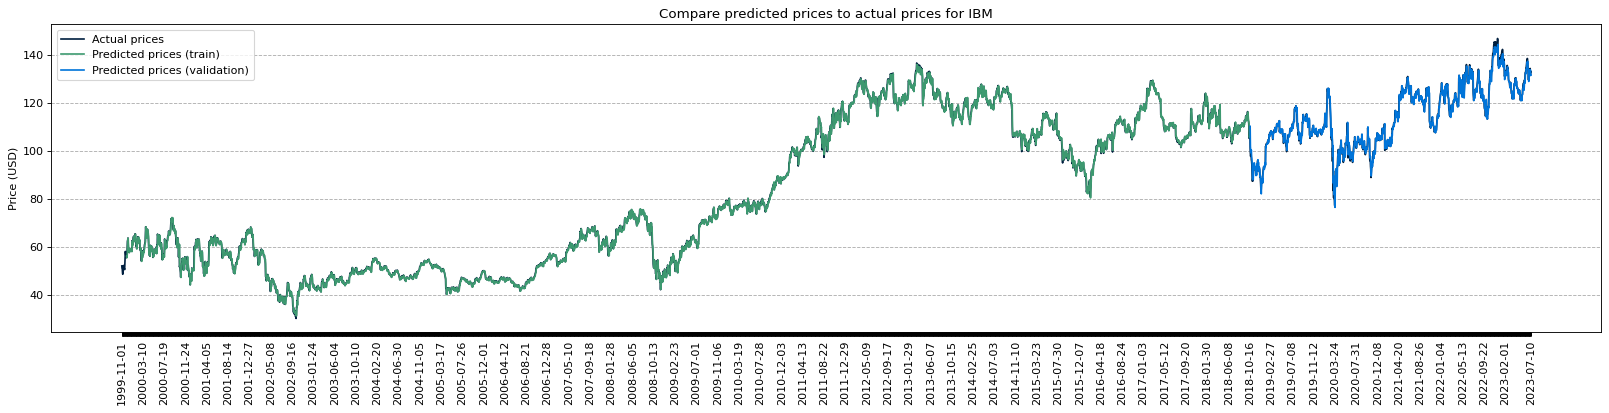

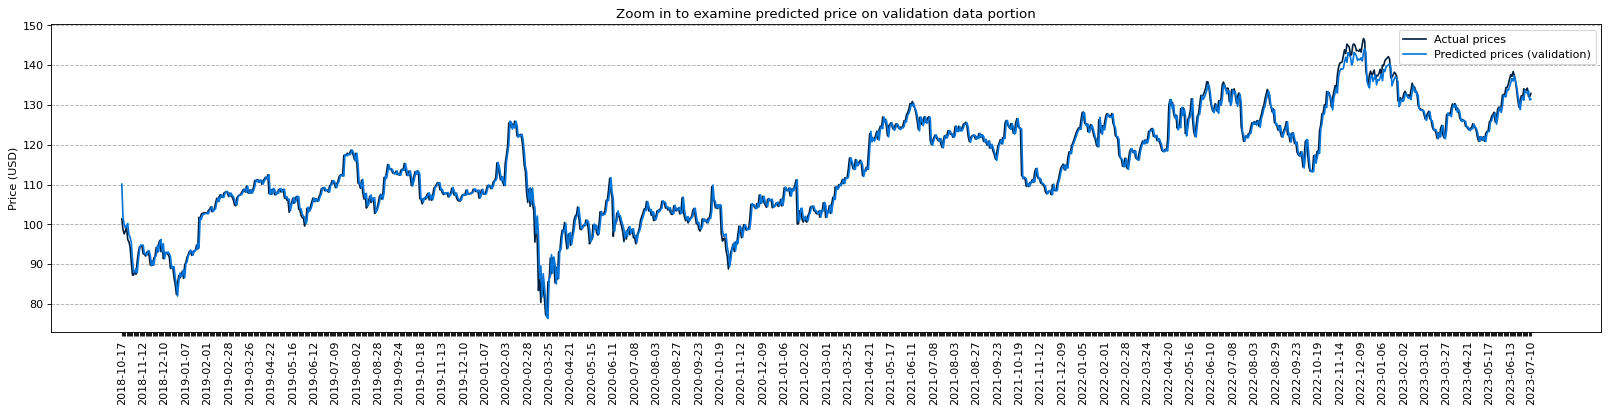

Predicted close price of the next trading day: $132.46


C:\Users\user\AppData\Local\Temp\ipykernel_36140\721097042.py:132: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test_pred[plot_range - 1] = scaler.inverse_transform(prediction)


In [9]:
# Prepare data for plotting
y_train_pred = np.zeros(num_data_points)
y_val_pred = np.zeros(num_data_points)

y_train_pred[
    config["data"]["window_size"] : split_index + config["data"]["window_size"]
] = scaler.inverse_transform(predicted_train)

y_val_pred[split_index + config["data"]["window_size"] :] = scaler.inverse_transform(
    predicted_val
)

y_train_pred = np.where(y_train_pred == 0, None, y_train_pred)
y_val_pred = np.where(y_val_pred == 0, None, y_val_pred)

# Plot the values by date
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.title(
    "Compare predicted prices to actual prices for {}".format(
        config["alpha_vantage"]["symbol"]
    )
)

xticks = [
    data_date[i]
    if (
        (
            i % config["plots"]["xticks_interval"] == 0
            and (num_data_points - i) > config["plots"]["xticks_interval"]
        )
        or i == num_data_points - 1
    )
    else None
    for i in range(num_data_points)
]

x = np.arange(0, len(xticks))
plt.xticks(x, xticks, rotation="vertical")
plt.grid(visible=True, which="major", axis="y", linestyle="--")

plt.ylabel("Price (USD)")

plt.plot(
    data_date,
    data_close_price,
    label="Actual prices",
    color=config["plots"]["color_actual"],
)

plt.plot(
    data_date,
    y_train_pred,
    label="Predicted prices (train)",
    color=config["plots"]["color_pred_train"],
)

plt.plot(
    data_date,
    y_val_pred,
    label="Predicted prices (validation)",
    color=config["plots"]["color_pred_val"],
)

plt.legend()
plt.show()

# Plotting the zoomed in view of the predicted prices vs. actual prices
y_val_subset = scaler.inverse_transform(data_y_val)
predicted_val = scaler.inverse_transform(predicted_val)
date = data_date[split_index + config["data"]["window_size"] :]

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.title("Zoom in to examine predicted price on validation data portion")

xticks = [
    date[i]
    if (
        (
            i % int(config["plots"]["xticks_interval"] / 5) == 0
            and (len(date) - i) > config["plots"]["xticks_interval"] / 6
        )
        or i == len(date) - 1
    )
    else None
    for i in range(len(date))
]

xs = np.arange(0, len(xticks))
plt.xticks(xs, xticks, rotation="vertical")
plt.grid(visible=True, which="major", axis="y", linestyle="--")

plt.ylabel("Price (USD)")

plt.plot(
    date,
    y_val_subset,
    label="Actual prices",
    color=config["plots"]["color_actual"],
)

plt.plot(
    date,
    predicted_val,
    label="Predicted prices (validation)",
    color=config["plots"]["color_pred_val"],
)

plt.legend()
plt.show()

# Predict the closing price of the next trading day
model.eval()

x = (
    torch.tensor(_data_x)
    .float()
    .to(config["training"]["device"])
    .unsqueeze(0)
    .unsqueeze(2)
)

prediction = model(x)
prediction = prediction.cpu().detach().numpy()

plot_range = 10
y_test_pred = np.zeros(plot_range)

y_test_pred[plot_range - 1] = scaler.inverse_transform(prediction)

y_test_pred = np.where(y_test_pred == 0, None, y_test_pred)

print(
    "Predicted close price of the next trading day: ${:.2f}".format(
        y_test_pred[plot_range - 1]
    )
)
